In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utilities import utils
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#### Analytics on model predictions

In [2]:
query = '''
    select
        model_id
      , avg(abs_error) as mean_absolute_error
      , 100 * sum(n_loss) / count(*) as loss_rate
    from dbt.evaluation
    group by model_id
    order by model_id
    '''
df = utils.query_db(query=query)
df.head(10)

,model_id,mean_absolute_error,loss_rate
0,s1,0.067579,61
1,s2,0.068829,62
2,s3,0.068356,58
3,s4,0.068719,53


In [3]:
query = '''
    select *
    from dbt.evaluation
    order by model_id, symbol, market_datetime
    '''
df = utils.query_db(query=query)
df.head(10)

,model_id,market_datetime,symbol,sector,industry,target,prediction,error,abs_error,is_loss,n_loss,mean_error_10,mean_error_30,mean_error_60,mean_error_90,max_error_10,max_error_30,max_error_60,max_error_90
0,s1,2019-02-01,A,Capital Goods,Biotechnology: Laboratory Analytical Instruments,75.07,73.946953,-0.014960,0.014960,False,0,0.014960,0.014960,0.014960,0.014960,0.014960,0.014960,0.014960,0.014960
1,s1,2019-02-04,A,Capital Goods,Biotechnology: Laboratory Analytical Instruments,75.07,74.041402,-0.013702,0.013702,False,0,0.014331,0.014331,0.014331,0.014331,0.014960,0.014960,0.014960,0.014960
2,s1,2019-02-05,A,Capital Goods,Biotechnology: Laboratory Analytical Instruments,75.07,74.265677,-0.010714,0.010714,False,0,0.013125,0.013125,0.013125,0.013125,0.014960,0.014960,0.014960,0.014960
3,s1,2019-02-06,A,Capital Goods,Biotechnology: Laboratory Analytical Instruments,75.07,75.228083,0.002106,0.002106,True,1,0.010370,0.010370,0.010370,0.010370,0.014960,0.014960,0.014960,0.014960
4,s1,2019-02-07,A,Capital Goods,Biotechnology: Laboratory Analytical Instruments,75.07,74.552388,-0.006895,0.006895,False,0,0.009675,0.009675,0.009675,0.009675,0.014960,0.014960,0.014960,0.014960
5,s1,2019-02-08,A,Capital Goods,Biotechnology: Laboratory Analytical Instruments,76.00,73.883821,-0.027844,0.027844,False,0,0.012704,0.012704,0.012704,0.012704,0.027844,0.027844,0.027844,0.027844
6,s1,2019-02-11,A,Capital Goods,Biotechnology: Laboratory Analytical Instruments,76.80,74.666278,-0.027783,0.027783,False,0,0.014858,0.014858,0.014858,0.014858,0.027844,0.027844,0.027844,0.027844
7,s1,2019-02-12,A,Capital Goods,Biotechnology: Laboratory Analytical Instruments,77.00,75.633191,-0.017751,0.017751,False,0,0.015219,0.015219,0.015219,0.015219,0.027844,0.027844,0.027844,0.027844
8,s1,2019-02-13,A,Capital Goods,Biotechnology: Laboratory Analytical Instruments,77.00,75.720883,-0.016612,0.016612,False,0,0.015374,0.015374,0.015374,0.015374,0.027844,0.027844,0.027844,0.027844
9,s1,2019-02-14,A,Capital Goods,Biotechnology: Laboratory Analytical Instruments,77.53,75.790452,-0.022437,0.022437,False,0,0.016080,0.016080,0.016080,0.016080,0.027844,0.027844,0.027844,0.027844


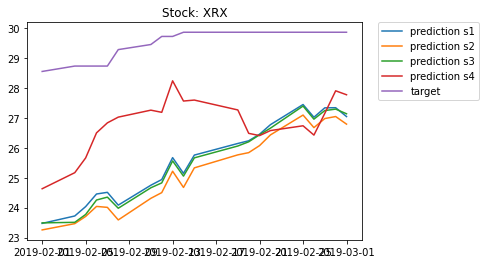

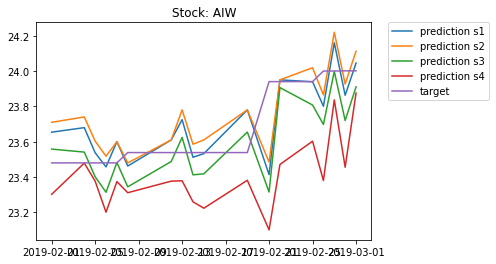

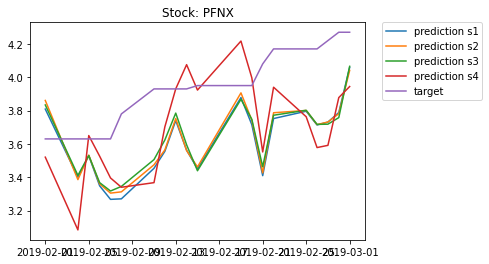

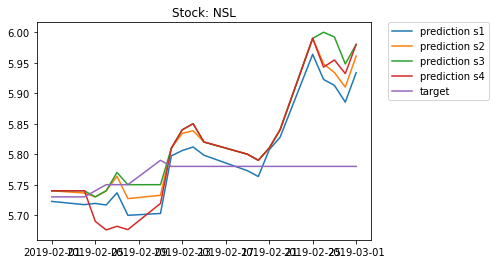

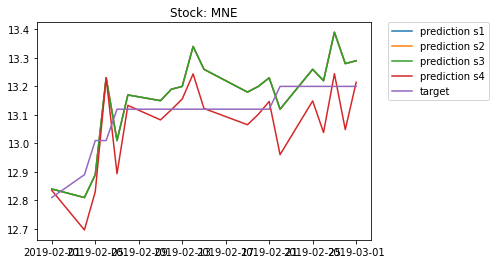

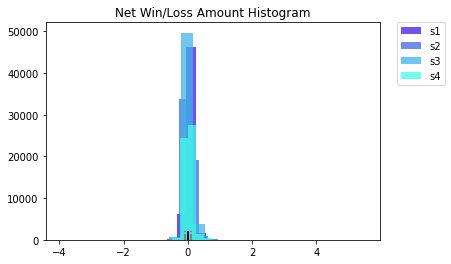

In [4]:
stocks = np.random.choice(df['symbol'].unique(), 5)
models = np.sort(df['model_id'].unique())
for s in stocks:
    temp = df[df['symbol']==s]
    for m in models:
        x = temp[temp['model_id']==m]
        plt.title(f'Stock: {s}')
        plt.plot(x['market_datetime'], x['prediction'], label=f'prediction {m}')
    plt.plot(x['market_datetime'], x['target'], label='target')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()

color_offset = 0.1
for m in models:
    temp = df[df['model_id']==m]
    plt.title(f'Net Win/Loss Amount Histogram')
    plt.hist(temp['error'], bins=25, ls='dashed', lw=2, fc=(.25, color_offset, .9, .75), label=m)
    plt.vlines(-.1, ymin=0, ymax=2000, color='grey', linestyles='dashed')
    plt.vlines(0, ymin=0, ymax=2000, color='black')
    plt.vlines(.1, ymin=0, ymax=2000, color='grey', linestyles='dashed')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    color_offset += .3
plt.show()

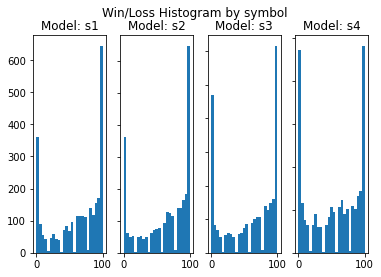

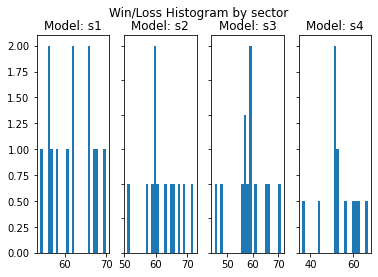

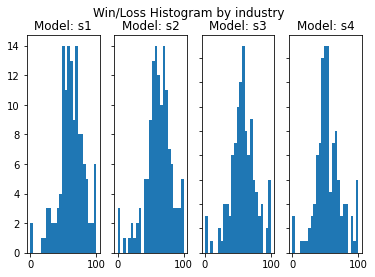

In [5]:
def groupby_plot(
    group
):
    query = f'''
        select
            model_id
          , {group}
          , 100 * sum(n_loss) / count(*) as loss_rate
        from dbt.evaluation
        group by 1,2
        '''
    df = utils.query_db(query=query)
    df.head(10)

    models = np.sort(df['model_id'].unique())
    n = len(models)

    fig, axs = plt.subplots(1, n)
    fig.suptitle(f'Win/Loss Histogram by {group}')
    for m in range(0, n):
        model = models[m]
        axs[m].set_title(f'Model: {model}')
        axs[m].hist(df.loc[df['model_id']==model, 'loss_rate'], bins=25)

    for ax in axs.flat:
        ax.label_outer()

    plt.show()

groupby_plot('symbol')
groupby_plot('sector')
groupby_plot('industry')

In [6]:
query = '''
    with
    s as (
    select distinct
        market_datetime::date
      , open / lag(open) over (order by market_datetime) as sp_open
    from yahoo.sp_index
    )
    select
        e.model_id
      , e.market_datetime
      , s.sp_open 
      , 100 * sum(e.n_loss) / count(*) as loss_rate
      , max(e.abs_error) as largest_daily_abs_error
      , avg(e.abs_error) as avg_abs_error
    from dbt.evaluation as e
    left join s
      on e.market_datetime = s.market_datetime
    group by 1,2,3
    order by 1,2,3
    '''
df = utils.query_db(query=query)
df.head(10)

,model_id,market_datetime,sp_open,loss_rate,largest_daily_abs_error,avg_abs_error
0,s1,2019-02-01,1.006267,52,1.686987,0.058049
1,s1,2019-02-04,1.001543,51,1.529760,0.058602
2,s1,2019-02-05,1.008073,60,1.863797,0.060711
3,s1,2019-02-06,1.002459,61,1.788789,0.058925
4,s1,2019-02-07,0.993594,54,1.806149,0.059681
5,s1,2019-02-08,0.990738,48,1.782912,0.059856
6,s1,2019-02-11,1.007443,49,2.133081,0.062585
7,s1,2019-02-12,1.003764,56,2.019962,0.064281
8,s1,2019-02-13,1.010170,60,4.427109,0.067059
9,s1,2019-02-14,0.997528,55,4.673994,0.065890


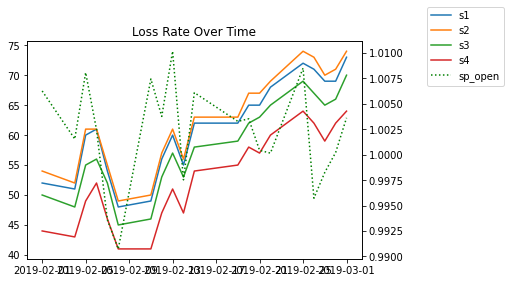

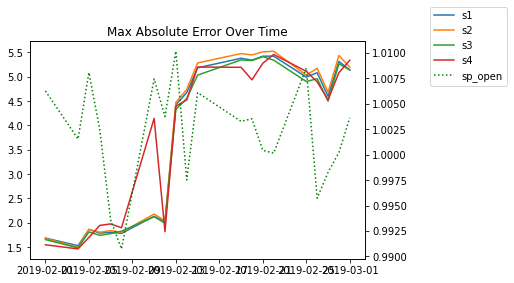

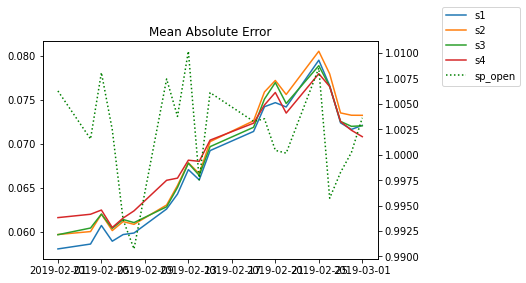

In [7]:
def multiplot(
    title,
    column,
):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    models = np.sort(df['model_id'].unique())
    for m in models:
        x = df[df['model_id']==m]
        plt.title(title)
        ax1.plot(x['market_datetime'], x[column], label=m)
    ax2.plot(x['market_datetime'], x['sp_open'], label='sp_open', color='g', linestyle=':')
    fig.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()

multiplot(
    title = 'Loss Rate Over Time',
    column = 'loss_rate',
)  

multiplot(
    title='Max Absolute Error Over Time',
    column='largest_daily_abs_error',
)

multiplot(
    title='Mean Absolute Error',
    column='avg_abs_error',
)